# More finalized plotting function

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import RNN_QSR
def getpaths(fn, include=[],alldir=False):
    """Looks in the directory folder and returns all paths in a dictionary which groups by system size
    Inputs:
        fn - The directory name you want to get all the folder paths from
        include - a list of keystrings which must be included in any path you search
    Outputs:
        A dictionary of L:[paths] pairs.
    """
    allpaths=dict()
    for paths,folders,files in os.walk(fn):
        #print(paths)
        Lcomp=paths.split("-")[0].split("\\")
        if len([a for a in include if a in paths])!=len(include):continue
        if len(paths.split("\\")[-1].split("-"))==1 and not alldir:continue
        if len(Lcomp)>2:
            Lcomp=int(Lcomp[2]) 
            if not Lcomp in allpaths:
                allpaths[Lcomp]=[paths]
            else:
                allpaths[Lcomp]+=[paths]
    return allpaths
allpaths=getpaths("out\\TFIM")      
print(allpaths.keys())


def errplt(out,*args,**kwargs):
    """Plots with nice error bars"""
    fmt=None
    
    args = [a for a in args]
    for i in range(len(args)):
        if type(args[i])==type(str()):fmt=args[i];del args[i]
    if len(args)<2:in_=np.arange(out.shape[0])
    if len(args)==1:errs=args[0]
    if len(args)==2:in_,out,errs=out,args[0],args[1]
    if len(args)>0:        
        if fmt!= None:
            plt.plot(in_,out,fmt,**kwargs)
            if not "color" in kwargs:
                c=fmt[0]
            else:
                c=kwargs["color"]
            plt.fill_between(in_,out-errs,out+errs,color=c,alpha=0.4,lw=0.0)
        else:
            plt.plot(in_,out,**kwargs)
            plt.fill_between(in_,out-errs,out+errs,alpha=0.4)
            

def graphs(allpaths,useTimes=False, metric="Sample",label_idx=1,err=False,smoothing=100):
    idx = {"SAMPLE":5,"CORRECTED":3,"TRAIN":1}[metric.upper()]
    for key in sorted(allpaths.keys()):

        fig = plt.figure(1,figsize=(6,2.5), dpi=240, facecolor='w', edgecolor='k')
        plt.title("L = %d %s Energy"%(key,metric))
        firstplot = True
        if key in RNN_QSR.TFIM.En1:
            exact_energy=RNN_QSR.TFIM.En1[key]
            
            if err:
                plt.ylim(-1e-3,5e-3)
            else:
                plt.yscale("log")
                plt.ylim(1e-5,5)
            
        elif key in RNN_QSR.Rydberg.E:
            exact_energy=RNN_QSR.Rydberg.E[key]
            if False:
                plt.ylim(-5e-3,1e-2)
            elif err:
                plt.ylim(-8e-4,8e-4)
            else:
                plt.yscale("log")
                plt.ylim(1e-5,5)
            
        else:
            plt.ylim(-1.28,-1.25)
            exact_energy=0

        print(key in RNN_QSR.Rydberg.E,exact_energy)
        bestmin=1e-5
        ends=[]
        for path in allpaths[key]:
            try:
                DEBUG = np.load(path+"\\DEBUG.npy")
            except:
                #print("Multiple Runs. . .")
                DEBUG=None
                count=0
                for paths,folders,files in os.walk(path):
                    for f in folders:
                        dbg = np.load(path+"\\"+f+"\\DEBUG.npy")
                        if type(DEBUG)==type(None):
                            DEBUG=dbg
                            #DEBUG=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                        else:
                            DEBUG+=dbg
                            #DEBUG+=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                            
                        count+=1
                DEBUG=DEBUG/count
                #DEBUG=np.exp(DEBUG/count)+exact_energy*key
            times=DEBUG[:,-1]/60
            ends+=[times.max()]
            
            #averaging
            avgs=np.array([np.mean(DEBUG[i:i+smoothing,idx]) for i in range(DEBUG.shape[0])])/key
            errs = np.array([np.var(DEBUG[i:i+smoothing,idx])**0.5 for i in range(DEBUG.shape[0])])/key
            
            outs=avgs
            if exact_energy!=0:
                if not err:
                    outs=np.clip(avgs,exact_energy+1e-5,10000)
                if outs.min()-exact_energy<bestmin:
                    bestmin=outs.min()-exact_energy
                    #plt.ylim(bestmin/2,5)
            
            #print(outs.mean())
            
            if type(label_idx)==type([]):
                tmp=path.split("-")
                label = "".join([tmp[i]+"," for i in label_idx])[:-1]
            else:
                label = path.split("-")[label_idx]
            
            print("L=%d %s: %f"%(key,label,avgs.min()),end="|")
            #plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,alpha=0.1,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
            if useTimes:
                x = plt.plot(times,outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
                plt.plot(times,exact_energy-avgs,'o',ms=1.5,c=x[0]._get_markerfacecolor(),alpha=0.1,markeredgewidth=0.2,markeredgecolor="black")

            else:
                if err:
                    errplt(outs-exact_energy,errs,"-",lw=0.5,label=label,color=np.random.random([3]))
                    plt.plot(outs*0,"k--",lw=0.2)
                else:
                    if key in RNN_QSR.Rydberg.Err and firstplot:
                        delta=RNN_QSR.Rydberg.Err[key]
                        plt.plot(outs*0+delta,"k--",lw=0.2,label="Error")
                    x = plt.plot(outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
                    plt.plot(exact_energy-avgs,'o',ms=1.5,c=x[0]._get_markerfacecolor(),alpha=0.1,markeredgewidth=0.2,markeredgecolor="black")
                    
                    
            firstplot=False
        print()
        if useTimes:
            
            if key in RNN_QSR.Rydberg.Err and not err:
                delta=RNN_QSR.Rydberg.Err[key]
                plt.plot([0,np.max(ends)],[delta,delta],"k--",lw=0.2,label="Error")
                
            plt.xlim(0,np.max(ends))
            plt.xlabel("Time (min)",fontsize=15)
        else:
            plt.xlabel("Step")
        plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
        plt.legend(loc="best",fontsize=6)
        plt.show()

dict_keys([10, 100, 36, 40, 500])


True -0.3724
L=576 PTFRNN\Rydberg\576: -0.372703|L=576 PTF\Rydberg\576: -0.372818|


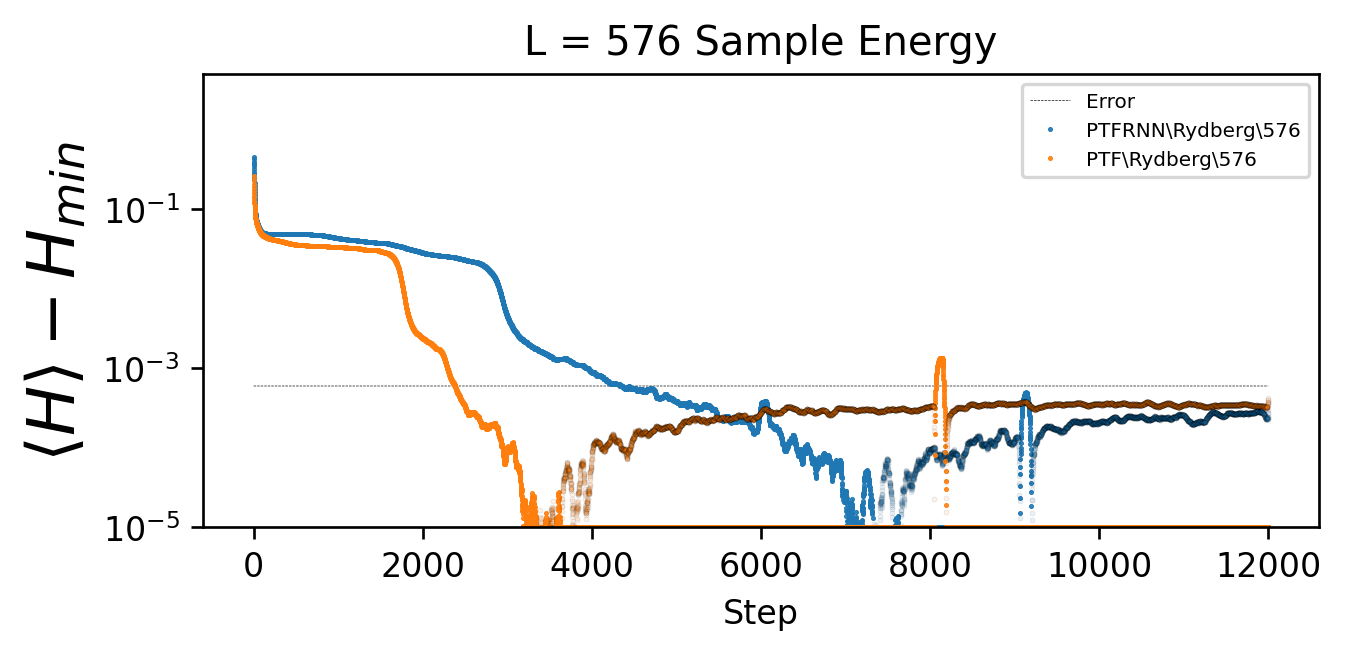

In [3]:
p = getpaths("PTFRNN\\Rydberg",["576"])
p[576] += getpaths("PTF\\Rydberg",["576"])[576]
graphs(p,useTimes=False, metric="Sample",label_idx=0,err=False,smoothing=100)

True -0.38052
L=256 PTFRNN\Rydberg\256,kl=0.00: -0.380685|L=256 PTF\Rydberg\256,kl=0.00\1: -0.380776|


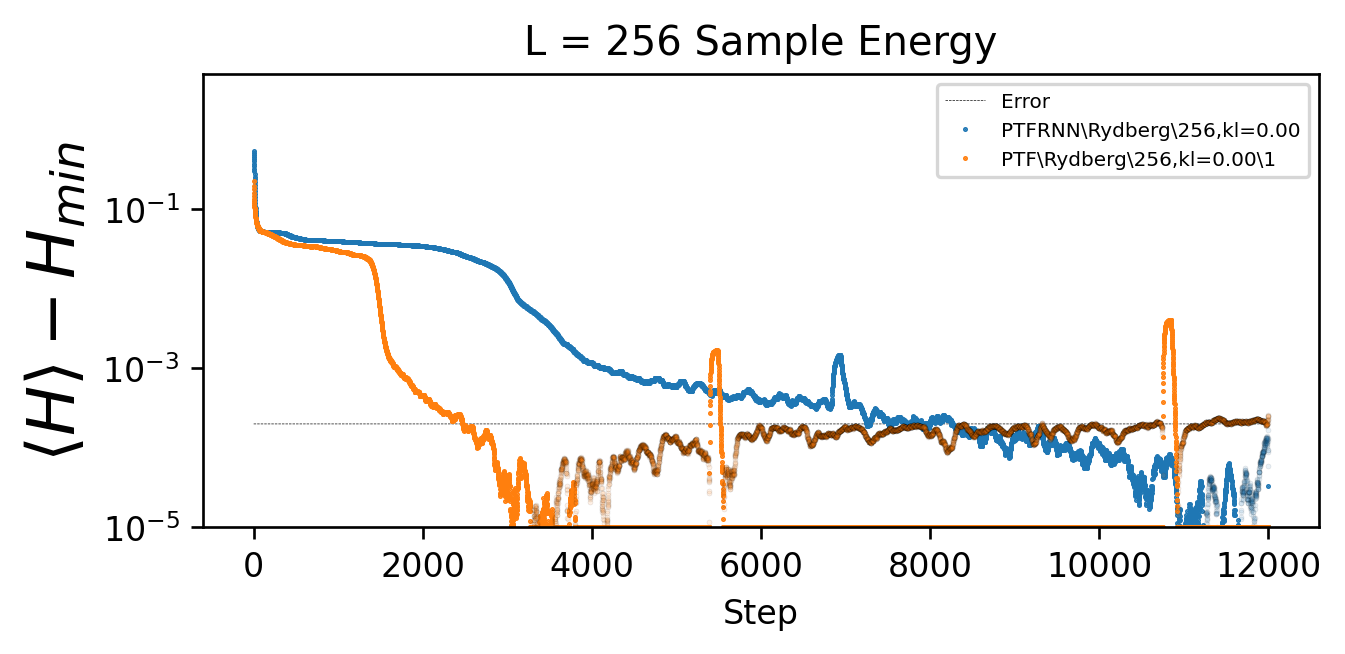

In [7]:
p = getpaths("PTFRNN\\Rydberg",["256-NoQ"])
p[256] += getpaths("PTF\\Rydberg",["256-NoQ","\\1"],alldir=True)[256]
graphs(p,useTimes=False, metric="Sample",label_idx=[0,-1],err=False,smoothing=100)

True -0.3687
L=1024 PTFRNN\Rydberg\1024,kl=0.00: -0.368765|L=1024 PTF\Rydberg\1024,kl=0.00: -0.368666|


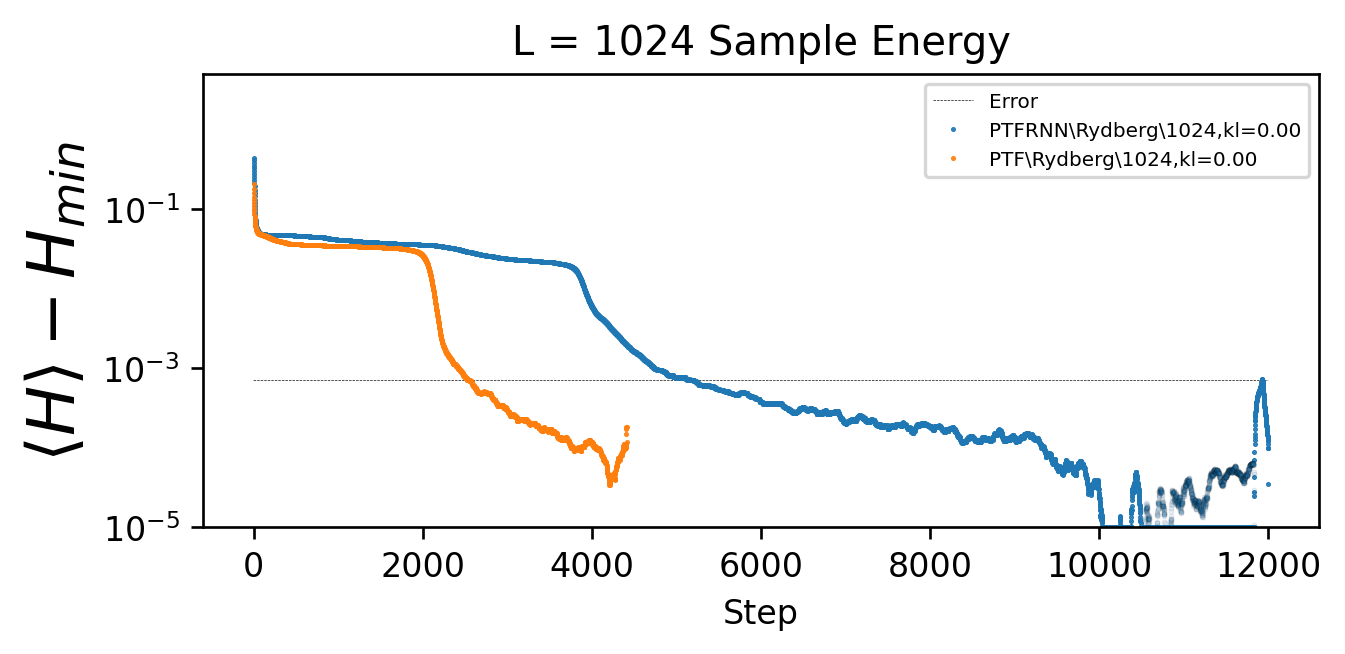

In [5]:
p = getpaths("PTFRNN\\Rydberg",["1024"])
p[1024] += getpaths("PTF\\Rydberg",["1024","K=64"],alldir=False)[1024]
graphs(p,useTimes=False, metric="Sample",label_idx=[0,-1],err=False,smoothing=100)

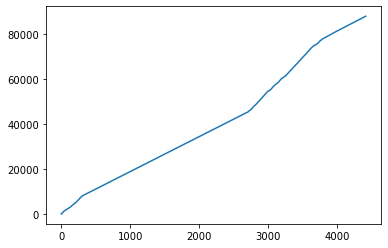

In [35]:
dbg = np.load("PTF\\Rydberg\\1024-NoQ-B=256-K=64-Nh=128-kl=0.00\\0\\DEBUG.NPY")
plt.plot(dbg[:,-1])

In [214]:

os.system("git commit -a -m \"Added kl divergence term\"")
os.system("git push origin")

0

True -0.38052
L=256 TF\Rydberg\256,kl=0.00\0: -0.377569|L=256 TF\Rydberg\256,kl=0.00\1: -0.380210|


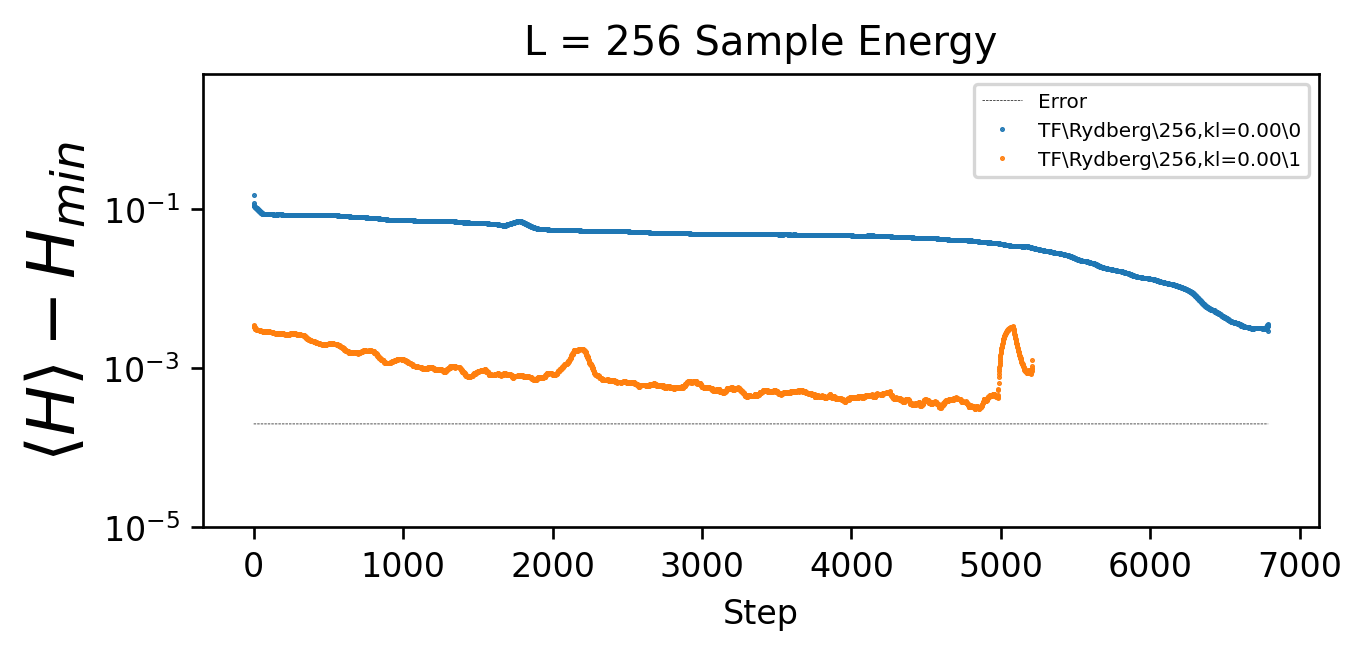

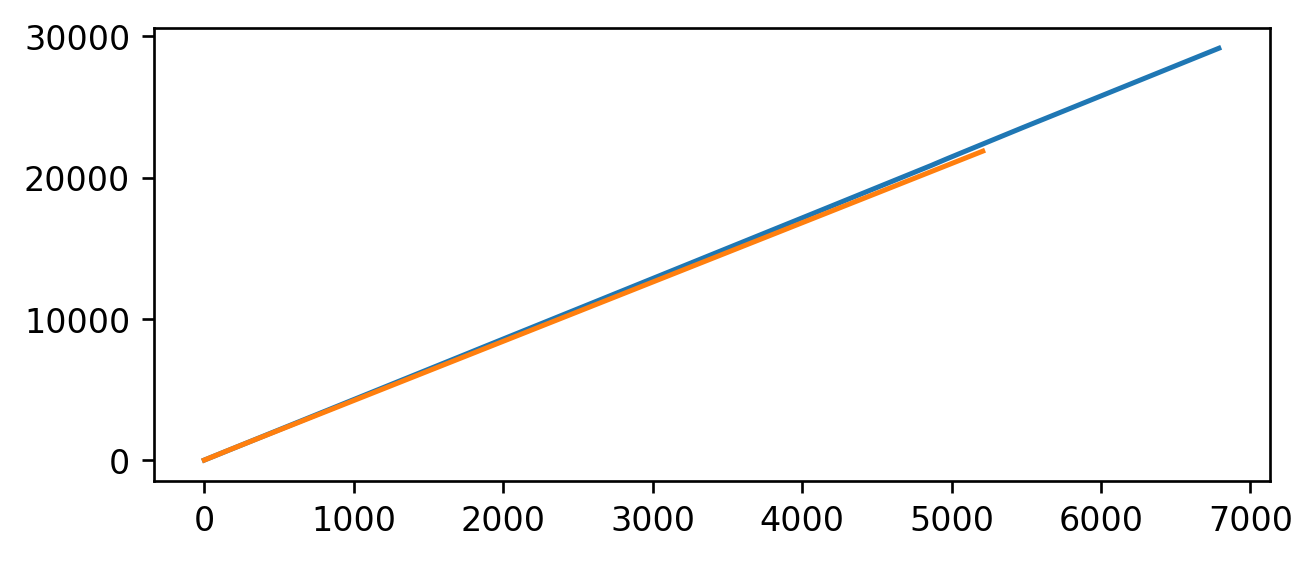

In [21]:
p=getpaths("TF\\Rydberg",["256","0.00\\"],alldir=True)
graphs(p,useTimes=False, metric="Sample",label_idx=[0,-1],err=False,smoothing=100)



fig = plt.figure(1,figsize=(6,2.5), dpi=240, facecolor='w', edgecolor='k')
debug0=np.load(p[256][0]+"\\DEBUG.npy")
debug1=np.load(p[256][1]+"\\DEBUG.npy")
plt.plot(debug0[:,-1])
plt.plot(debug1[:,-1])

#p = getpaths("PTFRNN\\Rydberg",["256","0.00\\"],alldir=True)
#debug2=np.load(p[256][0]+"\\DEBUG.npy")
#plt.plot(debug2[:,-1])